In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import datasets, transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm 

In [2]:
# make dataloader
def create_dataloader(transform):
    test_dl = None
    train_datasets = datasets.CelebA(root='/home/image/CelebA/data/', split="train", target_type='attr', download=False, transform=transform)
    train_dl = DataLoader(train_datasets,   batch_size=TRAIN_BATCH_SIZE, shuffle=True)

    test_dataset = datasets.CelebA(root='/home/image/CelebA/data/', split="test", target_type='attr', download=False, transform=transform)
    test_dl = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False)
    
    return train_dl, test_dl

In [3]:
class Generator(nn.Module):
    def __init__(self, nz, ngf):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(ngf, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    def forward(self, x):
        return self.main(x)

class Discriminator(nn.Module):
    def __init__(self, ndf):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf*4, ndf*8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf*8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
            
        )
    def forward(self, x):
        return self.main(x).squeeze()


In [4]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('Linear') != -1:        # 全結合層の場合
        m.weight.data.normal_(0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [17]:
#Conditional GAN

# Constants
EPOCH_NUM = 10
TRAIN_BATCH_SIZE = 256
TEST_BATCH_SIZE = 8
device = f"cuda:{0}" if torch.cuda.is_available() else "cpu"

transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5),(0.5))])

train_dl, test_dl = create_dataloader(transform)

nz = 100
ngf = 64
ndf = 64
netG = Generator(nz,ngf).to(device)
netG.apply(weights_init)
netD = Discriminator(ndf).to(device)
netD.apply(weights_init)

criterion = nn.BCELoss()

optim_D = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999), weight_decay=1e-5)
optim_G = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999), weight_decay=1e-5)

G_loss_list, D_loss_list = [], []
best_loss_G, best_loss_D = None,None

testdata, _ = next(iter(test_dl))
testdata = testdata[0].to(device)

for epoch in range(EPOCH_NUM):
    D_x, D_G_z1, D_G_z2 = 0, 0, 0
    iter_num = 0

    for datas, _ in train_dl:
        iter_num += 1
        real_img = datas.to(device)
        img_num = real_img.size(0)

        noise = torch.randn(img_num, nz, 1, 1, device=device)

        real_target = torch.full((img_num,), 1., device=device)
        fake_target = torch.full((img_num,), 0., device=device)
        #########################################
        netD.zero_grad()
        
        logits_real = netD(real_img)
        loss_real = criterion(logits_real, real_target)
        D_x = logits_real.mean().item()

        fake_img = netG(noise)
        logits_fake = netD(fake_img.detach())
        loss_fake = criterion(logits_fake, fake_target)
        D_G_z1 = logits_fake.mean().item()            

        loss_D = loss_real + loss_fake
        D_loss_list.append(loss_D.item())

        loss_D.backward()
        optim_D.step()
        
        ####################################
        netG.zero_grad()

        logits_fake_G = netD(fake_img)
        loss_G = criterion(logits_fake_G, real_target)
        D_G_z2 = logits_fake_G.mean().item()
        G_loss_list.append(loss_G.item())

        loss_G.backward()
        optim_G.step()
        
        ####################################
        if iter_num%200 == 0:
            print('EPOCH:{:}, iter:{:}, loss_D={:.3}, loss_G={:.3}, D(x)={:.3}, D(G(z))={:.3}/{:.3}'.format(epoch, iter_num, loss_D, loss_G, D_x, D_G_z1, D_G_z2))
            torch.save(netD.state_dict(), "checkpoints/DCGAN_CelebA_netD.pth")
            torch.save(netG.state_dict(), "checkpoints/DCGAN_CelebA_netG.pth")
        if epoch==0 or best_loss_D >= loss_D:
            best_loss_D = loss_D
        if epoch==0 or best_loss_G >= loss_G:
            best_loss_G = loss_G

print('Best loss_D={:.3} Best loss_G={:.3}'.format(best_loss_D, best_loss_G))


EPOCH:0, iter:200, loss_D=0.47, loss_G=3.14, D(x)=0.858, D(G(z))=0.233/0.0625
EPOCH:0, iter:400, loss_D=0.436, loss_G=3.85, D(x)=0.763, D(G(z))=0.0894/0.0384
EPOCH:0, iter:600, loss_D=0.821, loss_G=6.23, D(x)=0.918, D(G(z))=0.452/0.00456
EPOCH:1, iter:200, loss_D=0.406, loss_G=4.03, D(x)=0.863, D(G(z))=0.183/0.03
EPOCH:1, iter:400, loss_D=0.591, loss_G=5.19, D(x)=0.919, D(G(z))=0.356/0.0103
EPOCH:1, iter:600, loss_D=0.846, loss_G=5.48, D(x)=0.91, D(G(z))=0.456/0.0107
EPOCH:2, iter:200, loss_D=0.497, loss_G=2.45, D(x)=0.695, D(G(z))=0.0481/0.12
EPOCH:2, iter:400, loss_D=0.742, loss_G=5.52, D(x)=0.912, D(G(z))=0.402/0.00881
EPOCH:2, iter:600, loss_D=0.624, loss_G=2.35, D(x)=0.632, D(G(z))=0.0541/0.148
EPOCH:3, iter:200, loss_D=0.634, loss_G=4.52, D(x)=0.87, D(G(z))=0.339/0.0193
EPOCH:3, iter:400, loss_D=0.77, loss_G=2.39, D(x)=0.577, D(G(z))=0.0661/0.149
EPOCH:3, iter:600, loss_D=0.534, loss_G=2.28, D(x)=0.673, D(G(z))=0.0581/0.142
EPOCH:4, iter:200, loss_D=0.401, loss_G=3.03, D(x)=0.857

In [ ]:

fig = plt.figure(figsize=(10.0, 5.0))
ax1 = fig.add_subplot(1,2,1)
ax1.plot(G_loss_list, 'b', label='G')
ax1.legend()
ax2 = fig.add_subplot(1,2,2)
ax2.plot(D_loss_list, 'r', label='D')
ax2.legend()
plt.show()

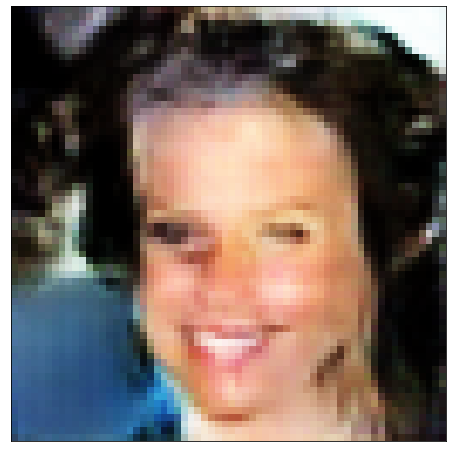

In [44]:
device = f"cuda:{0}" if torch.cuda.is_available() else "cpu"
nz = 100
ngf = 64
netG = Generator(nz,ngf).to(device)
netG.load_state_dict(torch.load("checkpoints/DCGAN_CelebA_netG.pth"))

fig = plt.figure(figsize=(8.0, 8.0))
fixed_noise = torch.randn(1, nz, 1, 1, device=device)
img = netG(fixed_noise)    
img = img.squeeze().cpu().detach().numpy()
img = img.squeeze().transpose(1,2,0)
mean,std=[0.5, 0.5, 0.5], [0.5, 0.5, 0.5]
img = img*np.array(std) + np.array(mean)
ax = fig.add_subplot(1,1,1,xticks=[], yticks=[])
ax.imshow(img)

In [5]:
class Classifier(nn.Module):
    def __init__(self, num_attributes):
        super(Classifier, self).__init__()
        self.classifier = torchvision.models.resnet18(pretrained=False)
        self.classifier.fc = nn.Linear(self.classifier.fc.in_features, num_attributes)
    def forward(self, x):
        y = self.classifier(x).sigmoid()
        return y

In [6]:
all_attributes = '5_o_Clock_Shadow Arched_Eyebrows Attractive Bags_Under_Eyes Bald Bangs Big_Lips Big_Nose Black_Hair Blond_Hair Blurry Brown_Hair Bushy_Eyebrows Chubby Double_Chin Eyeglasses Goatee Gray_Hair Heavy_Makeup High_Cheekbones Male Mouth_Slightly_Open Mustache Narrow_Eyes No_Beard Oval_Face Pale_Skin Pointy_Nose Receding_Hairline Rosy_Cheeks Sideburns Smiling Straight_Hair Wavy_Hair Wearing_Earrings Wearing_Hat Wearing_Lipstick Wearing_Necklace Wearing_Necktie Young'.split(' ')
relevant_attributes = ['Black_Hair', 'Blond_Hair', 'Eyeglasses','Smiling' ]
relevant_indices = []
for i, a in enumerate(all_attributes):
    if a in relevant_attributes:
        relevant_indices.append(i)
relevant_indices = torch.tensor(relevant_indices)
index_to_string = {i:all_attributes[j.item()] for i,j in enumerate(relevant_indices)}
index_to_string

{0: 'Black_Hair', 1: 'Blond_Hair', 2: 'Eyeglasses', 3: 'Smiling'}

In [7]:
def one_epoch(model, dl, device, criterion, optimizer=None):
    if optimizer:
        model.train()
    else:
        model.eval()

    losses = 0
    data_num = 0
    iter_num = 0

    for datas, targets in tqdm(dl):
        datas, targets = datas.to(device), targets.to(device)
        targets = targets[:,relevant_indices].float()
        data_num += len(targets)
        iter_num += 1

        if optimizer:
            logits = model(datas)
            loss = criterion(logits, targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        else:
            with torch.no_grad():
                logits = model(datas)
                loss = criterion(logits, targets)
            
        losses += loss.item()

    return losses/iter_num
        

In [8]:
def train(model, train_dl, test_dl, epoch, device, criterion, optimizer, early_stop=5, valid_dl=None):

    train_loss_list, valid_loss_list, train_accuracy_list, valid_accuracy_list = [],[],[],[]
    best_train_loss, best_train_acc, best_valid_loss, best_valid_acc = None, None, None, None
    count = 0
    
    for i in range(epoch):
        train_loss = one_epoch(model, train_dl, device, criterion, optimizer)

        if i==0 or best_train_loss >= train_loss:
            best_train_loss = train_loss
        
        if valid_dl:
            valid_loss = one_epoch(model, valid_dl, device, criterion)
            valid_loss_list.append(valid_loss)

            if i%1 == 0:
                print('EPOCH:{:}, Train: loss={:.3} Valid: loss={:.3}'.format(i,train_loss, valid_loss))

            if i==0 or best_valid_loss >= valid_loss:
                best_valid_loss = valid_loss
                test_loss = one_epoch(model, test_dl, device, criterion)
                count = 0
            else:
                count += 1
                print('early stopping count = {:}'.format(count))
        
            if count >= early_stop:
                print('early stoping : final epoch = {:}'.format(i))
                break   
        else:
            print('EPOCH:{:}, Train: loss={:.3}'.format(i,train_loss))

    print('Best train loss={:.3} Test loss={:.3}'.format(best_train_loss, test_loss))

    return np.array(train_loss_list), np.array(valid_loss_list), np.array(train_accuracy_list), np.array(valid_accuracy_list)

In [55]:
EPOCH_NUM = 10
TRAIN_BATCH_SIZE = 256
TEST_BATCH_SIZE = 8
VALID_BATCH_SIZE = 256
device = f"cuda:{0}" if torch.cuda.is_available() else "cpu"

transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5),(0.5))])

train_dl, test_dl = create_dataloader(transform)
valid_dataset = datasets.CelebA(root='/home/image/CelebA/data/', split="valid", target_type='attr', download=False, transform=transform)
valid_dl = DataLoader(valid_dataset, batch_size=VALID_BATCH_SIZE, shuffle=False)

netC = Classifier(4)
netC.to(device)
optim_C = optim.Adam(netC.parameters(), lr=0.00005, betas=(0.5, 0.999), weight_decay=0.005)
criterion = nn.BCELoss()

_, _, _, _ = train(netC, train_dl, test_dl, EPOCH_NUM, device, criterion, optim_C, valid_dl=valid_dl)
torch.save(netC.state_dict(), "checkpoints/DCGAN_CelebA_netC2.pth")

  0%|          | 5/2496 [00:00<00:57, 43.25it/s]

EPOCH:0, Train: loss=0.244 Valid: loss=0.188


  0%|          | 4/2496 [00:00<01:03, 39.29it/s]

EPOCH:1, Train: loss=0.178 Valid: loss=0.176


  0%|          | 5/2496 [00:00<00:57, 43.24it/s]

EPOCH:2, Train: loss=0.159 Valid: loss=0.174


  0%|          | 0/636 [00:00<?, ?it/s]

EPOCH:3, Train: loss=0.145 Valid: loss=0.175
early stopping count = 1


  0%|          | 0/636 [00:00<?, ?it/s]

EPOCH:4, Train: loss=0.128 Valid: loss=0.184
early stopping count = 2


  0%|          | 0/636 [00:00<?, ?it/s]

EPOCH:5, Train: loss=0.112 Valid: loss=0.189
early stopping count = 3


  0%|          | 0/636 [00:00<?, ?it/s]

EPOCH:6, Train: loss=0.0942 Valid: loss=0.284
early stopping count = 4


100%|██████████| 78/78 [00:51<00:00,  1.51it/s]


EPOCH:7, Train: loss=0.0778 Valid: loss=0.227
early stopping count = 5
early stoping : final epoch = 7
Best train loss=0.0778 Test loss=0.179


In [56]:
BLACK_HAIR_INDEX = 0
BLOND_HAIR_INDEX = 1
EYEGLASSES_INDEX = 2
SMILE_INDEX=3
mean,std=[0.5, 0.5, 0.5], [0.5, 0.5, 0.5]
nz = 100
ngf = 64

netG = Generator(nz,ngf).to(device)
netG.load_state_dict(torch.load("checkpoints/DCGAN_CelebA_netG.pth"))


<All keys matched successfully>

tensor(0.5247, device='cuda:0', grad_fn=<SigmoidBackward>)
tensor(0.6784, device='cuda:0', grad_fn=<SigmoidBackward>)
tensor(0.7210, device='cuda:0', grad_fn=<SigmoidBackward>)
tensor(0.7242, device='cuda:0', grad_fn=<SigmoidBackward>)
tensor(0.7270, device='cuda:0', grad_fn=<SigmoidBackward>)


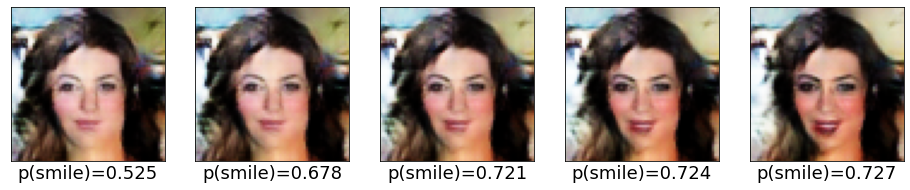

In [82]:
z = torch.randn(1, nz, 1, 1, device=device).requires_grad_()
lr=0.1
fake_history=[]
smile_p_history = []
num = 5
for i in range(num):
    netC.zero_grad()
    fake = netG(z)
    smile_p = netC(fake).squeeze(0)[SMILE_INDEX]
    smile_p.backward()
    z.data = z + (z.grad*lr)

    fake_history.append(fake.squeeze(0).cpu().detach().numpy())
    smile_p_history.append(smile_p.sigmoid())
    print(smile_p.sigmoid())
    
fig = plt.figure(figsize=(16.0, 16.0))
for i in range(num):
    img = fake_history[i]
    img = img.transpose(1,2,0)
    img = img*np.array(std) + np.array(mean)
    ax = fig.add_subplot(1,num,i+1,xticks=[], yticks=[])
    ax.set_xlabel(f'p(smile)={smile_p_history[i]:.3f}',fontsize=18)
    ax.imshow(img)

tensor(0.6925, device='cuda:0', grad_fn=<SigmoidBackward>)
tensor(0.7299, device='cuda:0', grad_fn=<SigmoidBackward>)
tensor(0.7309, device='cuda:0', grad_fn=<SigmoidBackward>)
tensor(0.7310, device='cuda:0', grad_fn=<SigmoidBackward>)
tensor(0.7310, device='cuda:0', grad_fn=<SigmoidBackward>)


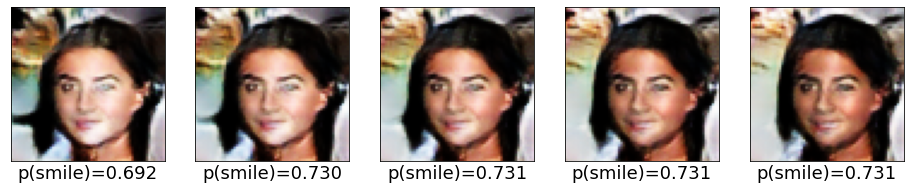

In [151]:
z = torch.randn(1, nz, 1, 1, device=device).requires_grad_()
lr=0.2
fake_history=[]
smile_p_history = []
num = 5
for i in range(num):
    netC.zero_grad()
    fake = netG(z)
    smile_p = netC(fake).squeeze(0)[BLACK_HAIR_INDEX]
    smile_p.backward()
    z.data = z + (z.grad*lr)

    fake_history.append(fake.squeeze(0).cpu().detach().numpy())
    smile_p_history.append(smile_p.sigmoid())
    print(smile_p.sigmoid())
    
fig = plt.figure(figsize=(16.0, 16.0))
for i in range(num):
    img = fake_history[i]
    img = img.transpose(1,2,0)
    img = img*np.array(std) + np.array(mean)
    ax = fig.add_subplot(1,num,i+1,xticks=[], yticks=[])
    ax.set_xlabel(f'p(smile)={smile_p_history[i]:.3f}',fontsize=18)
    ax.imshow(img)